In [1]:
import torch
import torch_geometric
import networkx as nx
from torch_geometric.utils import to_networkx
from ogb.linkproppred import PygLinkPropPredDataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
dataset = PygLinkPropPredDataset(name="ogbl-biokg", root='dataset/')

split_edge = dataset.get_edge_split()
train_edge, valid_edge, test_edge = split_edge["train"], split_edge["valid"], split_edge["test"]
graph = dataset[0]

print(graph)

Data(
  num_nodes_dict={
    disease=10687,
    drug=10533,
    function=45085,
    protein=17499,
    sideeffect=9969,
  },
  edge_index_dict={
    (disease, disease-protein, protein)=[2, 73547],
    (drug, drug-disease, disease)=[2, 5147],
    (drug, drug-drug_acquired_metabolic_disease, drug)=[2, 63430],
    (drug, drug-drug_bacterial_infectious_disease, drug)=[2, 18554],
    (drug, drug-drug_benign_neoplasm, drug)=[2, 30348],
    (drug, drug-drug_cancer, drug)=[2, 48514],
    (drug, drug-drug_cardiovascular_system_disease, drug)=[2, 94842],
    (drug, drug-drug_chromosomal_disease, drug)=[2, 316],
    (drug, drug-drug_cognitive_disorder, drug)=[2, 34660],
    (drug, drug-drug_cryptorchidism, drug)=[2, 128],
    (drug, drug-drug_developmental_disorder_of_mental_health, drug)=[2, 14314],
    (drug, drug-drug_endocrine_system_disease, drug)=[2, 55994],
    (drug, drug-drug_fungal_infectious_disease, drug)=[2, 36114],
    (drug, drug-drug_gastrointestinal_system_disease, drug)=[2, 8321

In [7]:
from torch_geometric.data import HeteroData
data = HeteroData()
for node_type, num_nodes in graph.num_nodes_dict.items():
    data[node_type].num_nodes = num_nodes
for edge_type, edge_index in graph.edge_index_dict.items():
    data[edge_type].edge_index = edge_index

In [9]:
print(data)

HeteroData(
  disease={ num_nodes=10687 },
  drug={ num_nodes=10533 },
  function={ num_nodes=45085 },
  protein={ num_nodes=17499 },
  sideeffect={ num_nodes=9969 },
  (disease, disease-protein, protein)={ edge_index=[2, 73547] },
  (drug, drug-disease, disease)={ edge_index=[2, 5147] },
  (drug, drug-drug_acquired_metabolic_disease, drug)={ edge_index=[2, 63430] },
  (drug, drug-drug_bacterial_infectious_disease, drug)={ edge_index=[2, 18554] },
  (drug, drug-drug_benign_neoplasm, drug)={ edge_index=[2, 30348] },
  (drug, drug-drug_cancer, drug)={ edge_index=[2, 48514] },
  (drug, drug-drug_cardiovascular_system_disease, drug)={ edge_index=[2, 94842] },
  (drug, drug-drug_chromosomal_disease, drug)={ edge_index=[2, 316] },
  (drug, drug-drug_cognitive_disorder, drug)={ edge_index=[2, 34660] },
  (drug, drug-drug_cryptorchidism, drug)={ edge_index=[2, 128] },
  (drug, drug-drug_developmental_disorder_of_mental_health, drug)={ edge_index=[2, 14314] },
  (drug, drug-drug_endocrine_syste

In [4]:
# Introductory Data Analysis

print(graph.num_nodes_dict)
total_nodes = sum(list(graph.num_nodes_dict.values()))
print(f"Total nodes: {total_nodes}")


{'disease': 10687, 'drug': 10533, 'function': 45085, 'protein': 17499, 'sideeffect': 9969}
Total nodes: 93773


In [5]:
print(graph.edge_index_dict.keys())
print(len(graph.edge_index_dict.keys()))
print(graph.edge_reltype.keys())
print(len(graph.edge_reltype.keys()))

dict_keys([('disease', 'disease-protein', 'protein'), ('drug', 'drug-disease', 'disease'), ('drug', 'drug-drug_acquired_metabolic_disease', 'drug'), ('drug', 'drug-drug_bacterial_infectious_disease', 'drug'), ('drug', 'drug-drug_benign_neoplasm', 'drug'), ('drug', 'drug-drug_cancer', 'drug'), ('drug', 'drug-drug_cardiovascular_system_disease', 'drug'), ('drug', 'drug-drug_chromosomal_disease', 'drug'), ('drug', 'drug-drug_cognitive_disorder', 'drug'), ('drug', 'drug-drug_cryptorchidism', 'drug'), ('drug', 'drug-drug_developmental_disorder_of_mental_health', 'drug'), ('drug', 'drug-drug_endocrine_system_disease', 'drug'), ('drug', 'drug-drug_fungal_infectious_disease', 'drug'), ('drug', 'drug-drug_gastrointestinal_system_disease', 'drug'), ('drug', 'drug-drug_hematopoietic_system_disease', 'drug'), ('drug', 'drug-drug_hematopoietic_system_diseases', 'drug'), ('drug', 'drug-drug_hypospadias', 'drug'), ('drug', 'drug-drug_immune_system_disease', 'drug'), ('drug', 'drug-drug_inherited_meta

In [6]:
print(train_edge.keys())
print(train_edge["head_type"][:5])
print(train_edge["head"][:5])
print(train_edge["relation"][:5])
print(train_edge["tail_type"][:5])
print(train_edge["tail"][:5])


dict_keys(['head_type', 'head', 'relation', 'tail_type', 'tail'])
['disease', 'disease', 'disease', 'disease', 'disease']
tensor([ 1718,  4903,  5480,  3148, 10300])
tensor([0, 0, 0, 0, 0])
['protein', 'protein', 'protein', 'protein', 'protein']
tensor([ 3207, 13662, 15999,  7247, 16202])


In [7]:
print(train_edge["head"].shape)
print(train_edge["head"].unique().shape)
print(train_edge["head"].max())
print(train_edge["head"].min())
print(train_edge["tail"].shape)
print(train_edge["tail"].unique().shape)
print(train_edge["tail"].max())
print(train_edge["tail"].min())

torch.Size([4762678])
torch.Size([44639])
tensor(45084)
tensor(0)
torch.Size([4762678])
torch.Size([45085])
tensor(45084)
tensor(0)


In [8]:
def get_outdegree(edges, idx):
    outdegree = torch.where(edges["head"] == idx, 1, 0).sum()
    return outdegree

def get_indegree(edges, idx):
    indegree = torch.where(edges["tail"] == idx, 1, 0).sum()
    return indegree

outdegrees = train_edge["head"].bincount()
indegrees = train_edge["tail"].bincount()

print(outdegrees[0])
print(indegrees[0])
print()
outdegree_max = torch.max(outdegrees)
outdegree_argmax = torch.argmax(outdegrees)
indegree_max = torch.max(indegrees)
indegree_argmax = torch.argmax(indegrees)
print(f"Outdegree Max: {outdegree_max}")
print(f"Outdegree ArgMax: {outdegree_argmax}")
print(f"Indegree Max: {indegree_max}")
print(f"Indegree ArgMax: {indegree_argmax}")

outdegree_mean = torch.mean(outdegrees.to(float))
indegree_mean = torch.mean(indegrees.to(float))
print(f"Outdegree Mean: {outdegree_mean}")
print(f"Indegree_Mean: {indegree_mean}")


tensor(27)
tensor(66)

Outdegree Max: 26670
Outdegree ArgMax: 6146
Indegree Max: 36089
Indegree ArgMax: 6146
Outdegree Mean: 105.63775091493845
Indegree_Mean: 105.63775091493845


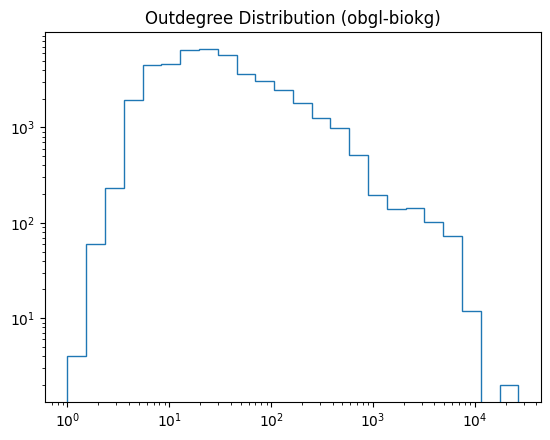

In [13]:
counts, bins = np.histogram(outdegrees, bins=np.logspace(np.log10(1), np.log10(outdegree_max), 25))
plt.stairs(counts, bins)
plt.xscale("log")
plt.yscale("log")
plt.title("Outdegree Distribution (obgl-biokg)")
plt.show()

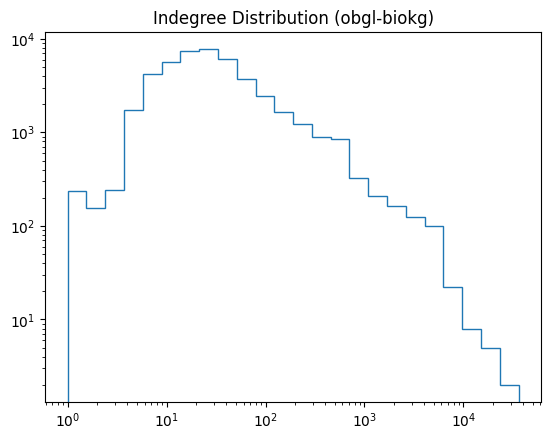

In [14]:
counts, bins = np.histogram(indegrees, bins=np.logspace(np.log10(1), np.log10(indegree_max), 25))
plt.stairs(counts, bins)
plt.xscale("log")
plt.yscale("log")
plt.title("Indegree Distribution (obgl-biokg)")
plt.show()

In [11]:
edge_list = torch.stack((train_edge["head"], train_edge["tail"]), dim=1)
# edge_list = zip(train_edge["head"], train_edge["tail"])

In [12]:
graph_nx = nx.from_edgelist(edge_list)